# Использование предобученных трансформеров

In [1]:
# %pip install --upgrade keras
# %pip install torch torchvision torchaudio

Большинство SOTA моделей последних лет основаны на 1 нейросетевой архитектуре, которая называется Transformer. Эта архитектура была представлена в 2017 году в статье - [Attention is all you need](https://arxiv.org/abs/1706.03762). 

На тот момент в обработке последовательностей доминировали рекуррентные нейроные сети, но у них была проблема с "забыванием" информации при обработке длинных текстов. Для решения этой проблемы был придуман механизм внимания (attention), который позволял на каждом шаге учитывать агрегированную информацию от всех предыдущих и последующих элементов. LSTM+Attention некоторое время был sota подходом, но в attention is all you need было показано, что можно получить те же результаты, используя по сути только механизм внимания, без рекуррентности. 

Отсутствие рекуррентности позволяет гораздо эффективнее распараллеливать вычисления как на 1 gpu/tpu так и на кластере. На тот момент уже было несколько исследований показывающих, что при увеличении количества параметров и данных, модели начинают вести себя неожиданно хорошо (например, у OpenAI была статья в которой они рассказывали, что оставили LSTM на несколько месяцев и потом обнаружили, что она научилась достаточно точно определять тональность текста (без обучения на размеченном датасете) - https://openai.com/blog/unsupervised-sentiment-neuron/). Рекуррентные сети не позволяли серьезно увеличивать размер сетей даже при наличие ресурсов, а трансформеры позволили. 

Все последующие годы регулярно появлялись (и продолжают появляться) все более и более объемные трансформерные модели (BERT, GPT-1,2,3, Megatron, PaLM, Lambda etc). Есть попытки масштабировать RNN модели тоже, но успешных примеров сильно меньше доступных трансформеров (стоит упомянуть [RWKV](https://github.com/BlinkDL/RWKV-LM) как самый удачный). 

Давайте попробуем чуть более подробно разобрать, как устроен трансформер. Это не простая тема и разбирать её мы будем постепенно.   
**В этом семинаре посмотрим в целом на архитектуру и ее ключевые элементы, а также попробуем использовать предобученные трансформерные модели (а точнее BERT) для задачи классификации.**

## Seq2seq

Для начала вернемся к рекуррентным сетям. Их недостатки наиболее серьезно проявились в задаче seq2seq. В seq2seq по входной последовательности нужно сгенерировать целевую последовательность, а длины последовательностей при этом могут отличаться. Самый каноничный пример seq2seq задачи - машинный перевод.

Использование LSTM* для машинного перевода можно схематически представить вот так:

*_тут и далее когда я говорю LSTM я на самом деле подразумеваю рекуррентные нейроные сети в целом, просто LSTM самый популярный их представитель, но уточнять это каждый раз неудобно_

![](https://i.ibb.co/XjP2Gmh/Lstm-seq2seq.png)

Для такой задачи нужно два LSTM слоя: один кодирует входную последовательность (encoder, или кодировщик), другой генерирует целевую последовательность (decoder или декодировщик). Такой подход работает, но есть серьезный недостаток - на вход декодеру подается только 1 вектор, в котором закодирована вся информация о целевой последовательности. Этот вектор - бутылочное горлышко (bottleneck), узкое место, в которое все упирается.

Если приводить аналогии, это как пытаться первести текст сходу целиком, прочитав его только 1 раз (попробуйте, например, перевести это предложение, не перечитывая). 

### Attention

Для устранения бутылочного горлышка стали использовать механизм внимания. Он дает декодирующей LSTM доступ ко всем состояниям энкодера, а не только к последнему. Это уже больше похоже на то, как человек переводит текст - текст прочитывается целиком, но при переводе можно возвращаться к каждому отдельному слову исходного текста.   

Схематично LSTM+Attention можно представить вот так. Такая архитектура уже в середине десятых годов позволила Google начать переход к нейронному переводу (до этого использовался статистический и правиловый):

![](https://i.ibb.co/bzwNqwC/lstm-attention-seq2seq.png)

Давайте подробнее посмотрим на механизм внимания. Визуализировать его целиком достаточно сложно, поэтому рассмотрим только 1 шаг (генерацию первого слова в переводе). 
![](https://i.ibb.co/19xB94B/lstm-attention-1-step.png)

Само внимание (или attention) можно реализовать разными способами. Мы рассмотрим один возможный подход - через скалярное произведение. 

После прохода энкодера для каждого элемента входной последовательности существует вектор состояния (его можно считать контекстным эмбедингом слова). На каждом шаге декодера между текущим состоянием декодера и всеми состояними энкодера расчитывается скалярное произведение (можно сказать считается близость между переводным словом и всеми словами входного текста). Результатом такого скалярного произведения является набор весов, соответствующих каждому слову входной последовательности. Эти веса показывают, какие слова релеванты для генерации текущего слова в переводе. 

Далее каждый вес умножается на соотвутсвующий ему вектор состояния энкодера и эти вектора прибавляются к текущему состоянию декодера (то есть происходит взвешенная сумма векторов слов входной последовательности и итоговая сумма прибавляется или конкатенируется к состояние декодера). 

Attention убрал существующий bottleneck, но обучать такие модели было очень тяжело, так как в основе был LSTM. В 2017 был предложен подход без использования рекуррентности - Transformer.

## Transformer 

Вот как схематично решается задача машинного перевода с помощью трансформера. Самим трансформером называется блок с вниманием и полносвязными слоями, то есть и энкодер и декодер состоят из идентичных трансформерных блоков. Как и другие слои - трансформерные блоки можно накладывать друг на друга. Количество таких блоков в энкодере и декодере - настраиваемый гиперпараметр модели. 
![](https://i.ibb.co/XY0GK2R/transformer.png)

В трансформерных блоках также есть heads, нормализация и skip-связи, но пока мы их пропустим. 

Attention в трансформере конечно не такой простой как на примере выше. Давайте посмотрим на визуализацию из вот этого поста https://jalammar.github.io/illustrated-transformer/ (его имеет смысл почитать целиком)

Attention также вычисляется через скалаярное произведение, но оно считается не между векторами напрямую. 

Каждый эмбединг одтельного слова преобразуется в 3 отдельных вектора с помощью полносвязного слоя (умножения на матрицу). У них есть названия: query вектор, key вектор и value вектор.

![](https://jalammar.github.io/images/t/transformer_self_attention_vectors.png)

Attention score вычисляется с помощью скалярного произведения query вектора текущего слова и key векторов всех слов в последовательности. Результат скалярного произведения пропускается через softmax, чтобы получить вероятности (это и есть оценки внимания, attention scores, высокая вероятность означает, что на это слово нужно обратить внимание, а низкий - что слово на текущем шаге не важно). 

Далее выполняется взвешенная сумма всех value векторов (веса = attention скоры). Полученный вектор уже передается дальше в полносвязный слой. При наслаивании транформерных блоков друг на друга на втором слое вместо эмбединга слова уже будет использоваться вектор полученный из предыдущего блока.

![](https://jalammar.github.io/images/t/self-attention-output.png)

Но это еще не все. Это пример того, что называется self-attention - когда внимание расчитыватся между элементами одной последовательности. На схеме выше еще есть cross-attention. Он используется в декодере - query вектор тут получается из эмбедингов слов в целевой последовательности, а key и value вектора получаются из выходных векторов энкодера. Cross-attention связывает энкодер и декодер.

Self-attention также присутствует в декодере. При обучении seq2seq моделей на вход подаются сразу две последовательности (текст и его перевод, например), но целевая последовательность подается постепенно (по 1 слову) и задача декодера - по полной входной последовательности и имеющейся на данный момент целевой последовательности сгенерировать продолжение. При использовании обученной модели для перевода текста сначала в декодер передается пустая последовательсть (а точнее не пустая а с тегом SOS или start, можно тут вспомнить семинар по языковым моделям).

#### Positional embedding

Еще одна важная составляющая транформера - positinal encoding (на схеме вместо обычного emded - pos emded), позиционной кодирование. Механизм внимания ничего не знает о позиции слов, он рассматривает последовательность как мешок слов, а от рекурентности мы избавились. Поэтому нужно как-то закодировать информацию о последовательности в эмбединги слов. В Attention is all you need это было сделано простым добавлением к эмбедингу слова вектора, который зависит от индекса слова в последовательности. В статье они использовали периодичные функции (синус и косинус), которые не нужно обучать - они просто возвращают какое-то значение на каждый индекс последовательности. Количество уникальных векторов генерируемых таким образом конечно ограничено, но очень большое количество и не требуется, так как транформер сам по себе не очень хорошо масштабируется на длинные последовательности (обычно ограниченивают максимальную длину около 512).

Вот визуализация позиционных векторов из того же поста (изображено 20 векторов - по строкам, каждый размерности 512 - колонки; видно как вектора меняются при увеличении индекса):

![](https://jalammar.github.io/images/t/transformer_positional_encoding_large_example.png)

В трансформере еще много других технических деталей, но для использования пока будет достаточно интуитивного понимания.

## Использование предобученных моделей

Транформеры также можно обучать в self-supervised формате (как word2vec) и использовать готовую модель для transfer learning. В 2018 вышел BERT (https://arxiv.org/abs/1810.04805), который показал насколько хорошо эта идея работает. BERT - это трансформерная модель, которая обучалась восстанавливать пропуски в тексте и определять соседние предложения. Данные для обучения BERT генерируются синтетически из сырого текста (например, берется предложение из вики и в нем случайно удаляются 20% токенов и их нужно восстановить). Авторы показали, что если дообучение предобученной BERT модели позволяет получить state-of-the-art результаты в большом количестве задач. 

Самое замечательное в том, что BERT был выложен в открытый доступ и им можно легко воспользоваться.

Давайте попробуем взять предобученные BERT и дообучить его решать задачу классификации текста.

In [4]:
# %pip install scikit-learn pandas matplotlib transformers

In [5]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
print(keras.__version__)

3.0.5


In [6]:
# стандартные библиотеки
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline


import keras, torch
from transformers import AutoModel
from transformers import AutoTokenizer


Возьмем данные lenta.ru, но не целиком. Fine-tuning больших моделей лучше всего подходит, когда данных совсем мало и стандартным алгоритмам просто не хватает информации, чтобы обучиться. Поэтому возьмем только небольшой процент всех данных.

In [5]:
# data_frac = pd.concat([data[data.topic=='Россия'].sample(frac=0.001),
#                       data[data.topic=='Мир'].sample(frac=0.001),
#                       data[data.topic=='Экономика'].sample(frac=0.002),
#                       data[data.topic=='Спорт'].sample(frac=0.003),
#                       data[data.topic=='Наука и техника'].sample(frac=0.005),
#                       data[data.topic=='Бывший СССР'].sample(frac=0.005),
#                       data[data.topic=='Культура'].sample(frac=0.005),
#                       data[data.topic=='Интернет и СМИ'].sample(frac=0.005),
#                       data[data.topic=='Из жизни'].sample(frac=0.01),
#                       data[data.topic=='Дом'].sample(frac=0.01),
#                       data[data.topic=='Силовые структуры'].sample(frac=0.01),
#                       data[data.topic=='Ценности'].sample(frac=0.03),
#                       data[data.topic=='Бизнес'].sample(frac=0.03),
#                       data[data.topic=='69-я параллель'].sample(frac=0.05),
#                       data[data.topic=='Крым'].sample(frac=0.05),
#                       data[data.topic=='Культпросвет'].sample(frac=0.2),
#                       data[data.topic=='Легпром'].sample(frac=0.8),
#                       data[data.topic=='Библиотека']]).reset_index(drop=True)

In [7]:
data = pd.read_csv('lenta_sample.csv')
data.dropna(subset=['topic', 'text'], inplace=True)

In [8]:
data.topic.value_counts()

Из жизни             55
Наука и техника      54
Бывший СССР          54
Культура             53
Ценности             45
Дом                  45
Бизнес               44
Интернет и СМИ       44
Силовые структуры    40
Спорт                39
Россия               32
Экономика            32
Мир                  27
69-я параллель       13
Легпром              13
Библиотека           10
Крым                  7
Name: topic, dtype: int64

In [9]:
data.shape

(607, 6)

### Загружаем предобученную модель из huggingface transformers

Список всех доступных моделей можно найти тут - https://huggingface.co/models  
А вот тут основные с описанием - https://huggingface.co/transformers/pretrained_models.html

На HG предпочитают торч, поэтому многие модели не загрузятся в тф. Там есть специальный тэг, по которому можно фильтровать модели. 

Другие виды моделей мы обсудим на следующем занятии, так как их очень много и они существенно отличаются друг от друга. Пока разберем 3 варианта BERT. 

In [10]:
# # Можно сказать оригинальный берт
# tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
# model_bert = AutoModel.from_pretrained('bert-base-cased')

In [11]:
# # # # Мультиязычный берт
# tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased')
# model_bert = AutoModel.from_pretrained('bert-base-multilingual-uncased')

In [12]:
# # # # дистилированный (т.е. уменьшенный) берт 
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")
model_bert = AutoModel.from_pretrained("distilbert-base-multilingual-cased")

2024-03-07 08:48:28.597778: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-07 08:48:30.143386: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Мы загружаем не только модель, а еще и токенайзер, т.е. свою предобработку нам писать не нужно

In [13]:
data.loc[4, 'title']

'По факту пожара на\xa0заводе в\xa0Югре заведено дело'

Перевести токены в индексы очень просто

In [14]:
tokenizer.encode(data.loc[4, 'title'])

[101,
 11480,
 61481,
 10227,
 10297,
 62323,
 10179,
 10122,
 69060,
 543,
 539,
 63596,
 10205,
 10234,
 48467,
 29112,
 102]

В этих моделях как правило используется BPE

In [15]:
# переводим индекс токена обратно в текст
encoded = tokenizer.encode(data.loc[4, 'title'])
[tokenizer.decode([x]) for x in encoded]

['[CLS]',
 'По',
 'факт',
 '##у',
 'по',
 '##жар',
 '##а',
 'на',
 'заводе',
 'в',
 'Ю',
 '##гр',
 '##е',
 'за',
 '##ведено',
 'дело',
 '[SEP]']

Индексы можно напрямую передавать в модель.

In [18]:
text = data.loc[4, 'title']
text_ids = tokenizer.encode(text, add_special_tokens=True, return_tensors='pt') # преобразуем в торч формат 
output = model_bert(text_ids, output_attentions=False)

На выходе мы получим tuple из двух элементов. 

Первый элемент - состояния енкодера для каждого из элементов последовательности

In [19]:
output[0].size() # в пайторче вместо .shape используется size()
output[0].shape # но shape тоже работает

torch.Size([1, 17, 768])

Второй - состояние енкодера на первом элементе, пропущенное через активацию (обычно этот элемент не используют)

In [20]:
# в дистилберт его совсем нет, поэтому будет ошибка
# output[1].shape

Обычно в задачах используют либо состояние первого элемента

In [21]:
output[0][:,0].shape

torch.Size([1, 768])

Либо усредненное состояние 

In [22]:
output[0].mean(axis=1).shape

torch.Size([1, 768])

Полученные эмбеддинги уже можно использовать для какой-нибудь кластеризации или поиска похожих. А если есть разметка, то можно обучить на этих векторах стандартную модель из sklearn или даже дообучить всего Берта под конкретную задачу!

Давайте попробуем дообучить (fine-tune) модель на данных lenta ru

Будем обучаться на заголовках, а не на самих текстах

In [23]:
# переводим тексты в последовательности индексов
# У берта есть ограничение на максимальную длину последовательности - 512
# Для заголовков это не очень актуально, но для других данных пригодится

X = []

for text in data.title:
    ids = tokenizer.encode(text)
    
    X.append(ids[:512])

In [24]:
X = keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

In [25]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])


In [26]:
X.shape

(607, 512)

В этот раз добавим стратификацию, т.к. в данных у нас дисбаланс классов.

In [27]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

In [28]:
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

Загруженную модель в tf.keras можно использовать просто как слой в нейронной сети. Давайте сделаем новую модель, которая будет принимать на вход индексы символьных нграмм, пропускать их через берт, и затем брать первый вектор из энкодера и классифицировать его.

У нас есть два варианты дообучения - обучать только последний классификатор, не трогая берт, либо обучать все целиком, используя предобученной состояние энкодера как отправную точку.

#### Дообучение с замораживанием предобученной модели

In [29]:
# если использовать tf как бекенд то заморозить веса можно специальным параметром
# model_bert = AutoModel.from_pretrained('distilbert-base-multilingual-cased', trainable=False)

model_bert = AutoModel.from_pretrained("distilbert-base-multilingual-cased")
# в торче веса замораживаются вот так
# если нужно заморозить не все, то нужно просто добавить условия в цикл
for param in model_bert.parameters():
    param.requires_grad = False

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:

input_word_ids = keras.layers.Input(shape=(512,), dtype=torch.int64,
                                     name="input_ids")

# модель нужно обернуть в специальный класс чтобы она была совместима с другими керас слоями
output = keras.layers.TorchModuleWrapper(model_bert)(input_word_ids)

# добавим дропаут чтобы не переобучалось
drop = keras.layers.Dropout(0.1)(output[0][:, 0]) # [0][:, 0] - означает что мы берем первое 
                                                     # состояние у всех текстов в батче
dense = keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = keras.Model(inputs=input_word_ids, outputs=dense)

# обычно при дообучении трансформеров нужно ставить очень маленький лосс
# но когда мы обучаем только итоговый классификатор то можно ставить побольше
model_clf.compile(keras.optimizers.Adam(learning_rate=1e-3), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', 
                           keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])




In [36]:
if torch.cuda.is_available():
    model_clf.to('cuda')

С батчсайзом тут приходится уже быть осторожным, т.к. берт занимает очень много места на видеокарте. 

In [35]:
# если есть ошибка с device meta то попробуйте запустить еще раз
model_clf.fit(torch.LongTensor(X_train), torch.LongTensor(y_train), 
          validation_data=(torch.LongTensor(X_valid), torch.LongTensor(y_valid)),
          batch_size=20,
          epochs=20)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.0940 - loss: 2.8592 - rec_prec: 0.0000e+00 - val_accuracy: 0.0968 - val_loss: 2.7488 - val_rec_prec: 0.0000e+00
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.0828 - loss: 2.7897 - rec_prec: 0.0000e+00 - val_accuracy: 0.0968 - val_loss: 2.6964 - val_rec_prec: 0.0323
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.0763 - loss: 2.7138 - rec_prec: 0.0000e+00 - val_accuracy: 0.0968 - val_loss: 2.7134 - val_rec_prec: 0.0000e+00
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.1076 - loss: 2.7098 - rec_prec: 0.0000e+00 - val_accuracy: 0.0645 - val_loss: 2.6937 - val_rec_prec: 0.0000e+00
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.1047 - loss: 2.7050 - rec_prec: 0.0000e+00 - val_accuracy: 0.1290 - val_loss: 2.7065 - val_rec_prec: 0.0000e+00
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.1140 - loss: 2.6984 - rec_prec: 0.0000e+00 - val_accur

dict_keys(['accuracy', 'loss', 'rec_prec', 'val_accuracy', 'val_loss', 'val_rec_prec'])


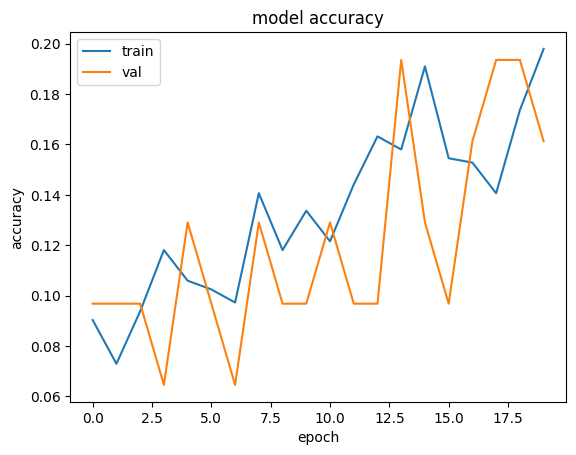

In [37]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [38]:
from sklearn.metrics import classification_report

In [39]:
pred = model_clf.predict(X_valid, batch_size=10).argmax(1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [40]:
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

      Бывший СССР       0.00      0.00      0.00         3
       Библиотека       0.00      0.00      0.00         0
              Дом       0.15      1.00      0.27         2
         Культура       0.00      0.00      0.00         3
              Мир       0.00      0.00      0.00         1
         Ценности       0.00      0.00      0.00         2
             Крым       0.00      0.00      0.00         0
  Наука и техника       0.00      0.00      0.00         3
Силовые структуры       0.33      0.50      0.40         2
            Спорт       0.00      0.00      0.00         2
   69-я параллель       0.00      0.00      0.00         1
   Интернет и СМИ       0.33      0.50      0.40         2
           Бизнес       1.00      0.50      0.67         2
        Экономика       0.00      0.00      0.00         2
          Легпром       0.00      0.00      0.00         1
           Россия       0.00      0.00      0.00       

Дообучение с замораживанием может не работать, давайте попробуем обучать все сразу

#### Дообучение без замораживания 

In [41]:
model_bert = AutoModel.from_pretrained('distilbert-base-multilingual-cased')
# по умолчанию веса обучаемые поэтому нужно просто загрузить модель

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [43]:
input_word_ids = keras.layers.Input(shape=(512,), dtype=torch.int64,
                                     name="input_ids")

output = keras.layers.TorchModuleWrapper(model_bert)(input_word_ids)
# берем только самый первый вектор (CLS токен)
drop = keras.layers.Dropout(0.1)(output[0][:, 0]) 
dense = keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = keras.Model(inputs=input_word_ids, outputs=dense)


model_clf.compile(keras.optimizers.Adam(learning_rate=2e-6,
                                    ), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', 
                           keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])




In [44]:
if torch.cuda.is_available():
    model_clf.to('cuda')

Батч сайз нужно поставить еще меньше

In [46]:
# если есть ошибка с device meta то попробуйте запустить еще раз
model_clf.fit(torch.LongTensor(X_train), torch.LongTensor(y_train), 
          validation_data=(torch.LongTensor(X_valid), torch.LongTensor(y_valid)),
          batch_size=4,
          epochs=10)

Epoch 1/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.0800 - loss: 2.8246 - rec_prec: 0.0000e+00 - val_accuracy: 0.0968 - val_loss: 2.7275 - val_rec_prec: 0.0000e+00
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.0739 - loss: 2.7322 - rec_prec: 0.0061 - val_accuracy: 0.1613 - val_loss: 2.7033 - val_rec_prec: 0.0000e+00
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.0955 - loss: 2.7306 - rec_prec: 0.0000e+00 - val_accuracy: 0.0968 - val_loss: 2.6623 - val_rec_prec: 0.0645
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.1353 - loss: 2.6578 - rec_prec: 1.0613e-04 - val_accuracy: 0.2903 - val_loss: 2.6432 - val_rec_prec: 0.0000e+00
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.1986 - loss: 2.5702 - rec_prec: 0.0061 - val_accuracy: 0.1613 - val_loss: 2.5566 - val_rec_prec: 0.0323
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.3209 - loss: 2.2735 - rec_prec: 0.0532 - val_acc

dict_keys(['accuracy', 'loss', 'rec_prec', 'val_accuracy', 'val_loss', 'val_rec_prec'])


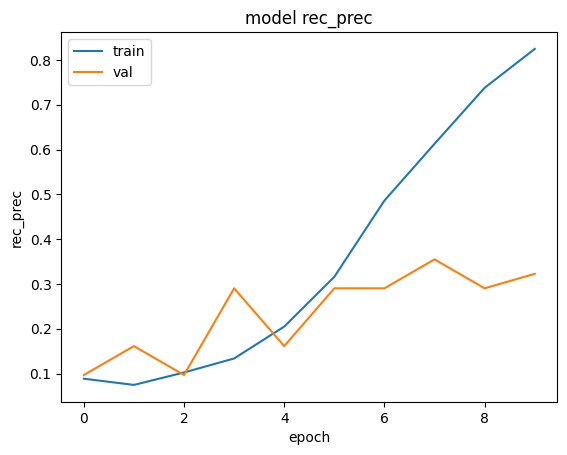

In [47]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [48]:
from sklearn.metrics import classification_report

In [49]:
pred = model_clf.predict(X_valid, batch_size=5).argmax(1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [50]:
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

      Бывший СССР       0.33      0.67      0.44         3
       Библиотека       0.00      0.00      0.00         0
              Дом       0.25      0.50      0.33         2
         Культура       1.00      0.33      0.50         3
              Мир       0.00      0.00      0.00         1
         Ценности       0.00      0.00      0.00         2
             Крым       0.00      0.00      0.00         0
  Наука и техника       0.60      1.00      0.75         3
Силовые структуры       0.50      0.50      0.50         2
            Спорт       0.00      0.00      0.00         2
   69-я параллель       0.00      0.00      0.00         1
   Интернет и СМИ       0.00      0.00      0.00         2
           Бизнес       0.50      0.50      0.50         2
        Экономика       0.00      0.00      0.00         2
          Легпром       0.00      0.00      0.00         1
           Россия       0.00      0.00      0.00       

Ф-мера выглядит не очень, но нужно помнить, что мы обучились на 600 примерах. Для сравнения можно попробовать обучить лстм на тех же данных (честнее было конечно обучить трансформер, но это не так просто).

In [52]:

def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

vocab = Counter()

for text in data.title:
    vocab.update(preprocess(text))

# индексируем слова
word2id = {'PAD':0}

for word in vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

X = []

for text in data.title:
    tokens = preprocess(text)
    ids = [word2id[token] for token in tokens]
    X.append(ids)

MAX_LEN = max(len(x) for x in X)


# паддинг
X = keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=MAX_LEN)


id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=data.topic)

In [53]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=False))(embeddings)
drop = keras.layers.Dropout(0.3)(lstm)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(drop)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [54]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 13, 30)         │        93,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       162,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 17)             │         4,369 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 260,245 (1016.58 KB)

 Trainable params: 260,245 (1016.58 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=50)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.0899 - loss: 2.8263 - val_accuracy: 0.0968 - val_loss: 2.7752
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.0847 - loss: 2.7526 - val_accuracy: 0.0968 - val_loss: 2.7002
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.0868 - loss: 2.6620 - val_accuracy: 0.0968 - val_loss: 2.6825
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.1026 - loss: 2.5957 - val_accuracy: 0.0645 - val_loss: 2.8663
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.1484 - loss: 2.2978 - val_accuracy: 0.0968 - val_loss: 3.0225
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2455 - loss: 2.1341 - val_accuracy: 0.0968 - val_loss: 2.8897
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3343 - loss: 1.8132 - val_accuracy: 0.0645 - val_loss: 3.0957
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3790 - loss: 1.6294 - val_accuracy: 0.0968 - v

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


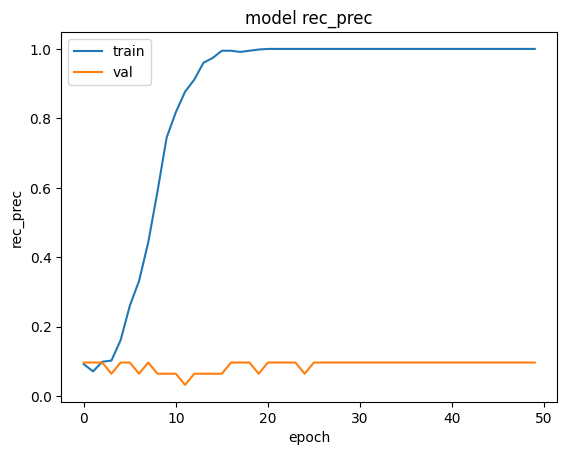

In [56]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [57]:
pred = model.predict(X_valid, batch_size=5).argmax(1)

print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
                   precision    recall  f1-score   support

      Бывший СССР       0.00      0.00      0.00         3
       Библиотека       0.00      0.00      0.00         0
              Дом       0.10      0.50      0.17         2
         Культура       0.00      0.00      0.00         3
              Мир       0.00      0.00      0.00         1
         Ценности       0.00      0.00      0.00         2
             Крым       0.00      0.00      0.00         0
  Наука и техника       0.00      0.00      0.00         3
Силовые структуры       0.00      0.00      0.00         2
            Спорт       1.00      0.50      0.67         2
   69-я параллель       0.00      0.00      0.00         1
   Интернет и СМИ       0.11      0.50      0.18         2
           Бизнес       0.00      0.00      0.00         2
        Экономика       0.00      0.00      0.00         2
          Легпром       0.00      0.00      0.00         1
           Россия

Модель очень сильно переобучается. Она полностью выучивает обучающую выборку, но с предсказанием новых данных все очень плохо (разрыв в качестве с предобученной моделью огромный). Увеличение количества параметров не поможет - будет точно такая же картина. Для того, чтобы увеличить качество необходимо больше данных. 